In [1]:
# allow to import modules from the project root directory
import sys
import os
# Add the project root directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..')))

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from src.ParObsSnakeEnv import ParObsSnakeEnv
import torch.nn.functional as F
import matplotlib.pyplot as plt
from src.utils import compute_metrics

In [3]:
# Simple Actor-Critic implementation
# Version №1
class Actor(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(Actor, self).__init__()
        self.num_actions = num_actions
        self.Dropout = nn.Dropout(p=0.4)
        self.fc1 = nn.Linear(num_inputs, 128)
        self.fc2 = nn.Linear(128, num_actions)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = self.Dropout(x)
        logits = self.fc2(x)
        return logits
    
    def choose_action(self, state):
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        logits = self.forward(state_tensor)
        action_probs = F.softmax(logits, dim=1)
        action = np.random.choice(self.num_actions, p=action_probs.detach().numpy()[0])
        return action, action_probs

class Critic(nn.Module):
    def __init__(self, num_inputs):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(num_inputs, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        value = self.fc2(x)
        return value

In [ ]:
# Updated Actor-Critic implementation (more complex)
# Version №2
class Actor(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(Actor, self).__init__()
        self.num_actions = num_actions
        self.Dropout = nn.Dropout(p=0.4)
        self.fc1 = nn.Linear(num_inputs, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, num_actions)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.Dropout(x)
        logits = self.fc4(x)
        return logits
    
    def choose_action(self, state):
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        logits = self.forward(state_tensor)
        action_probs = F.softmax(logits, dim=1)
        action = np.random.choice(self.num_actions, p=action_probs.detach().numpy()[0])
        return action, action_probs

class Critic(nn.Module):
    def __init__(self, num_inputs):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(num_inputs, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        value = self.fc4(x)
        return value

In [15]:
# Version №3
class Actor(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(Actor, self).__init__()
        self.num_actions = num_actions
        self.dropout1 = nn.Dropout(p=0.4)
        self.dropout2 = nn.Dropout(p=0.3)
        self.fc1 = nn.Linear(num_inputs, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_actions)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        logits = torch.relu(self.fc3(x))
        return logits
    
    def choose_action(self, state):
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        logits = self.forward(state_tensor)
        action_probs = F.softmax(logits, dim=1)
        action = np.random.choice(self.num_actions, p=action_probs.detach().numpy()[0])
        return action, action_probs

class Critic(nn.Module):
    def __init__(self, num_inputs):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(num_inputs, 256)
        self.dropout = nn.Dropout(p=0.4)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        value = torch.relu(self.fc3(x))
        return value

In [4]:
env = ParObsSnakeEnv(grid_size=10, interact=False)
num_actions = env.action_space.n
num_inputs = env.observation_space.shape[0]

In [13]:
gamma = 0.99
actor_lr = 0.0001
critic_lr = 0.0001
num_episodes = 5000

In [16]:
actor = Actor(num_inputs, num_actions)
actor.load_state_dict(torch.load('../../models/actor_v3.pth'))
critic = Critic(num_inputs)
criterion = nn.MSELoss()
episode_reward_list = list()

In [21]:
# Initialize optimizers and learning rate schedulers
actor_optimizer = optim.Adam(actor.parameters(), lr=0.001)
critic_optimizer = optim.Adam(critic.parameters(), lr=0.001)

In [22]:
# Initialize lists to store statistics
actor_losses = []
critic_losses = []
episode_rewards = []

# Training loop
for episode in tqdm(range(num_episodes), desc="Training Episodes"):
    state = env.reset()
    done = False
    episode_reward = 0

    while not done:
        action, action_probs = actor.choose_action(state)
        next_state, reward, done, _ = env.step(action)
        episode_reward += reward

        if done:
            reward = -1

        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)

        value = critic(state_tensor)
        next_value = critic(next_state_tensor)

        target_value = reward + gamma * next_value * (1 - int(done))
        advantage = target_value - value

        actor_loss = -torch.log(action_probs[0, action]) * advantage.item()
        critic_loss = criterion(value, target_value.detach())

        actor_optimizer.zero_grad()
        critic_optimizer.zero_grad()

        actor_loss.backward()
        critic_loss.backward()

        actor_optimizer.step()
        critic_optimizer.step()

        state = next_state

    # Store statistics
    actor_losses.append(actor_loss.item())
    critic_losses.append(critic_loss.item())
    episode_rewards.append(episode_reward)

Training Episodes: 100%|██████████| 5000/5000 [21:51<00:00,  3.81it/s]


In [23]:
# save the models 
torch.save(actor.state_dict(), "../../models/actor_v3.pth")
torch.save(critic.state_dict(), "../../models/critic_v3.pth")

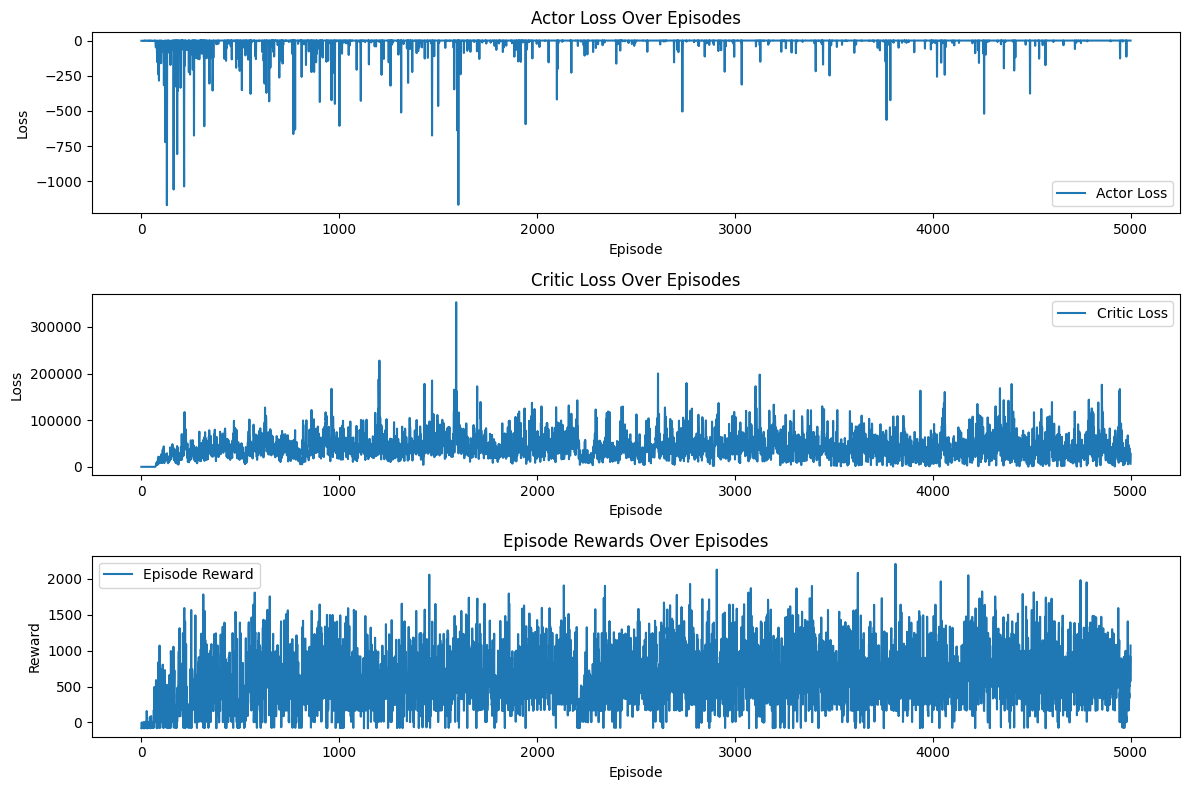

In [24]:
# Plotting the statistics
plt.figure(figsize=(12, 8))

# Plot actor losses
plt.subplot(3, 1, 1)
plt.plot(actor_losses, label='Actor Loss')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.title('Actor Loss Over Episodes')
plt.legend()

# Plot critic losses
plt.subplot(3, 1, 2)
plt.plot(critic_losses, label='Critic Loss')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.title('Critic Loss Over Episodes')
plt.legend()

# Plot episode rewards
plt.subplot(3, 1, 3)
plt.plot(episode_rewards, label='Episode Reward')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Episode Rewards Over Episodes')
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
env = ParObsSnakeEnv(grid_size=20, interact=False)

In [10]:
from src.utils import compute_metrics

In [18]:
stats = compute_metrics(actor, env, "../../artifacts/models_stats/actor_critic/actor_critic_v3_sim.json", num_simulations=100)

  2%|▏         | 2/100 [00:00<00:06, 14.66it/s]

Snake length: 7, Episode reward: 432
Snake length: 12, Episode reward: 929
Snake length: 2, Episode reward: 29
Snake length: 10, Episode reward: 689
Snake length: 6, Episode reward: 393


  6%|▌         | 6/100 [00:00<00:04, 20.74it/s]

Snake length: 9, Episode reward: 687
Snake length: 27, Episode reward: 2220


  9%|▉         | 9/100 [00:00<00:07, 12.14it/s]

Snake length: 15, Episode reward: 1168
Snake length: 9, Episode reward: 676


 11%|█         | 11/100 [00:00<00:08, 10.34it/s]

Snake length: 23, Episode reward: 1844
Snake length: 14, Episode reward: 1068


 13%|█▎        | 13/100 [00:01<00:09,  9.56it/s]

Snake length: 18, Episode reward: 1453
Snake length: 15, Episode reward: 1181
Snake length: 14, Episode reward: 1049


 17%|█▋        | 17/100 [00:01<00:08, 10.30it/s]

Snake length: 19, Episode reward: 1495
Snake length: 4, Episode reward: 180
Snake length: 9, Episode reward: 648


 19%|█▉        | 19/100 [00:01<00:08,  9.65it/s]

Snake length: 7, Episode reward: 455
Snake length: 28, Episode reward: 2328


 21%|██        | 21/100 [00:01<00:07, 10.42it/s]

Snake length: 9, Episode reward: 611
Snake length: 20, Episode reward: 1584
Snake length: 12, Episode reward: 902
Snake length: 4, Episode reward: 192


 27%|██▋       | 27/100 [00:02<00:05, 13.91it/s]

Snake length: 11, Episode reward: 802
Snake length: 8, Episode reward: 556
Snake length: 6, Episode reward: 369
Snake length: 20, Episode reward: 1568


 31%|███       | 31/100 [00:02<00:05, 13.36it/s]

Snake length: 21, Episode reward: 1670
Snake length: 8, Episode reward: 516
Snake length: 6, Episode reward: 369
Snake length: 15, Episode reward: 1203


 33%|███▎      | 33/100 [00:02<00:05, 12.59it/s]

Snake length: 10, Episode reward: 723
Snake length: 13, Episode reward: 999
Snake length: 11, Episode reward: 799
Snake length: 4, Episode reward: 190


 39%|███▉      | 39/100 [00:02<00:03, 18.49it/s]

Snake length: 7, Episode reward: 449
Snake length: 12, Episode reward: 842
Snake length: 6, Episode reward: 380
Snake length: 5, Episode reward: 269
Snake length: 43, Episode reward: 3676
Snake length: 11, Episode reward: 834


 44%|████▍     | 44/100 [00:03<00:05, 10.60it/s]

Snake length: 22, Episode reward: 1763
Snake length: 13, Episode reward: 959
Snake length: 20, Episode reward: 1637


 47%|████▋     | 47/100 [00:03<00:04, 12.80it/s]

Snake length: 7, Episode reward: 445
Snake length: 12, Episode reward: 862
Snake length: 8, Episode reward: 546


 49%|████▉     | 49/100 [00:04<00:05,  9.30it/s]

Snake length: 28, Episode reward: 2288
Snake length: 21, Episode reward: 1634
Snake length: 12, Episode reward: 866


 53%|█████▎    | 53/100 [00:04<00:03, 11.78it/s]

Snake length: 9, Episode reward: 649
Snake length: 2, Episode reward: 34
Snake length: 15, Episode reward: 1153
Snake length: 6, Episode reward: 374


 57%|█████▋    | 57/100 [00:04<00:02, 14.38it/s]

Snake length: 9, Episode reward: 671
Snake length: 12, Episode reward: 904
Snake length: 4, Episode reward: 178
Snake length: 7, Episode reward: 416
Snake length: 9, Episode reward: 631


 62%|██████▏   | 62/100 [00:04<00:02, 15.60it/s]

Snake length: 13, Episode reward: 1009
Snake length: 12, Episode reward: 853
Snake length: 11, Episode reward: 824
Snake length: 9, Episode reward: 686


 64%|██████▍   | 64/100 [00:05<00:02, 15.16it/s]

Snake length: 12, Episode reward: 867
Snake length: 19, Episode reward: 1531


 66%|██████▌   | 66/100 [00:05<00:02, 12.49it/s]

Snake length: 11, Episode reward: 838
Snake length: 21, Episode reward: 1670


 68%|██████▊   | 68/100 [00:05<00:02, 11.51it/s]

Snake length: 11, Episode reward: 860
Snake length: 12, Episode reward: 931


 72%|███████▏  | 72/100 [00:05<00:02, 10.63it/s]

Snake length: 22, Episode reward: 1791
Snake length: 11, Episode reward: 823
Snake length: 17, Episode reward: 1305


 74%|███████▍  | 74/100 [00:06<00:02, 10.11it/s]

Snake length: 9, Episode reward: 623
Snake length: 5, Episode reward: 306
Snake length: 3, Episode reward: 117


 78%|███████▊  | 78/100 [00:06<00:01, 12.28it/s]

Snake length: 19, Episode reward: 1546
Snake length: 12, Episode reward: 896
Snake length: 4, Episode reward: 177
Snake length: 11, Episode reward: 824


 82%|████████▏ | 82/100 [00:06<00:01, 11.62it/s]

Snake length: 15, Episode reward: 1172
Snake length: 7, Episode reward: 494
Snake length: 18, Episode reward: 1446


 86%|████████▌ | 86/100 [00:07<00:01, 13.04it/s]

Snake length: 10, Episode reward: 719
Snake length: 6, Episode reward: 372
Snake length: 10, Episode reward: 733
Snake length: 13, Episode reward: 1011


 90%|█████████ | 90/100 [00:07<00:00, 14.04it/s]

Snake length: 10, Episode reward: 726
Snake length: 13, Episode reward: 990
Snake length: 12, Episode reward: 899
Snake length: 7, Episode reward: 427


 92%|█████████▏| 92/100 [00:07<00:00, 11.73it/s]

Snake length: 7, Episode reward: 452
Snake length: 28, Episode reward: 2330


 96%|█████████▌| 96/100 [00:07<00:00, 13.75it/s]

Snake length: 8, Episode reward: 543
Snake length: 7, Episode reward: 442
Snake length: 14, Episode reward: 1079
Snake length: 8, Episode reward: 548


 98%|█████████▊| 98/100 [00:07<00:00, 13.98it/s]

Snake length: 11, Episode reward: 792
Snake length: 9, Episode reward: 664
Snake length: 18, Episode reward: 1491


100%|██████████| 100/100 [00:08<00:00, 12.08it/s]

Snake length: 8, Episode reward: 545


In [19]:
snake_lengths = stats['snake_lengths']
episode_rewards = stats['episode_rewards']

Average Snake Length: 12.09
Average Episode Reward: 907.89


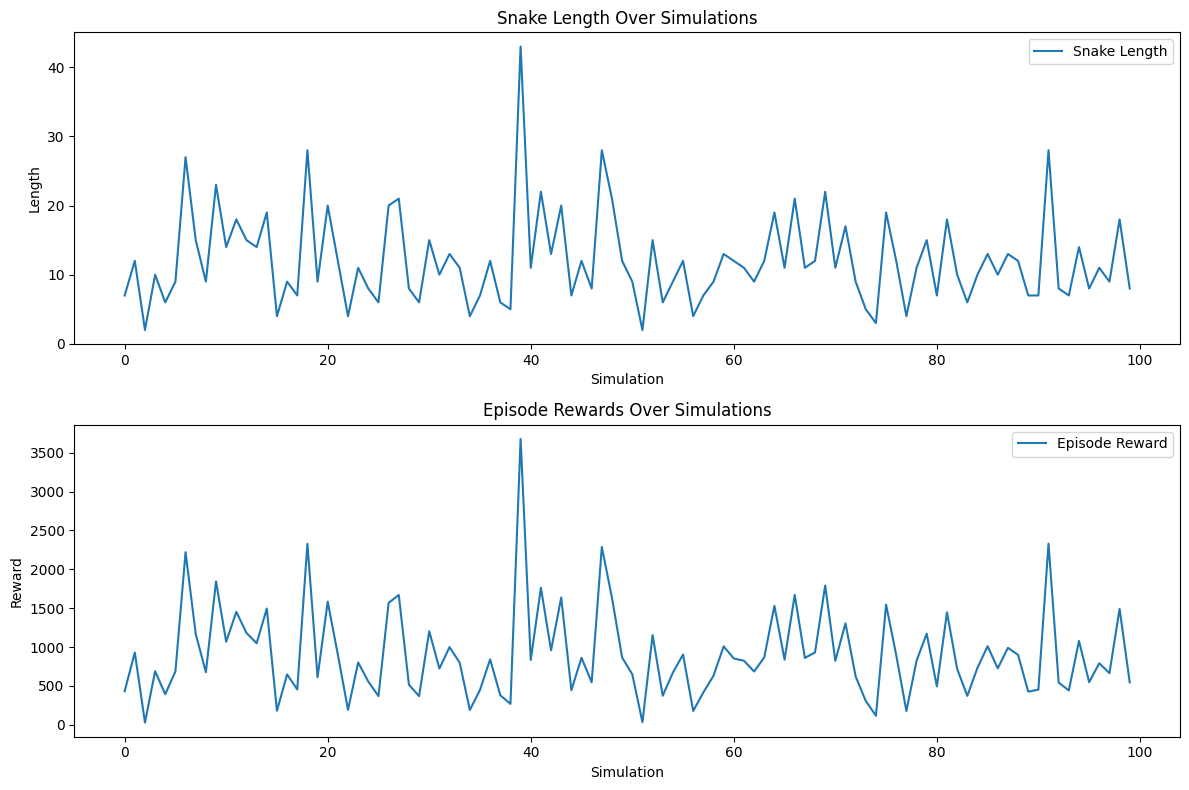

In [20]:
# Print metrics
print("Average Snake Length:", np.mean(snake_lengths))
print("Average Episode Reward:", np.mean(episode_rewards))

# Plotting the metrics
plt.figure(figsize=(12, 8))

# Plot snake lengths
plt.subplot(2, 1, 1)
plt.plot(snake_lengths, label='Snake Length')
plt.xlabel('Simulation')
plt.ylabel('Length')
plt.title('Snake Length Over Simulations')
plt.legend()

# Plot episode rewards
plt.subplot(2, 1, 2)
plt.plot(episode_rewards, label='Episode Reward')
plt.xlabel('Simulation')
plt.ylabel('Reward')
plt.title('Episode Rewards Over Simulations')
plt.legend()

plt.tight_layout()
plt.show()